# Setup #

In [6]:
import os
import glob
import PIL
import torch
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

In [7]:
DEVICE = torch.device("cpu")
print(DEVICE)

cpu


# Data Loading #

Tuning:
1. Imitate model architecture of existing networks e.g. VGG, ResNet
2. Data Augmentation for monet images

In [8]:
MONET_IMAGES = tf.io.gfile.glob("./monet_jpg/*.jpg")
PHOTO_IMAGES = tf.io.gfile.glob("./photo_jpg/*.jpg")

In [9]:
# Normalize all the values to be between -1 and 1
def decode_image(images):
    decoded_images = []
    for image in images:
        image = np.asarray(Image.open(image)).astype("float32")
        image = tf.convert_to_tensor(image) # numpy -> tensor
        shape = image.shape
        image = tf.cast(image, tf.float32) / 127.5 - 1
        image = tf.reshape(image, shape)
        decoded_images.append(image)
    return decoded_images

In [10]:
monet_decoded = decode_image(MONET_IMAGES)
photo_decoded = decode_image(PHOTO_IMAGES)
# need to specify batch size for training subsequent models
monet_ds = tf.data.Dataset.from_tensor_slices(monet_decoded).batch(1) # list -> dataset
photo_ds = tf.data.Dataset.from_tensor_slices(photo_decoded).batch(1)

2023-04-30 21:28:54.719842: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
print("Monet files:", len(monet_ds))
print("Photo files: ", len(photo_ds))

Monet files: 300
Photo files:  7038


In [12]:
monet_example = next(iter(monet_ds))
photo_example = next(iter(photo_ds))

2023-04-30 21:38:31.630268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [300,256,256,3]
	 [[{{node Placeholder/_0}}]]
2023-04-30 21:38:37.263475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [7038,256,256,3]
	 [[{{node Placeholder/_0}}]]


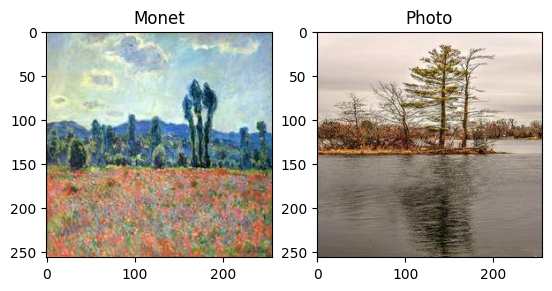

In [13]:
plt.subplot(1,2,1)
plt.title("Monet")
plt.imshow((monet_example[0]+1)/2)

plt.subplot(1,2,2)
plt.title("Photo")
plt.imshow((photo_example[0]+1)/2)

# Generator #

Our generator is based on a U-Net architecture. A U-Net has a contracting path is composed of a series of convolutional and pooling layers that reduce the spatial dimensionality of the input image while increasing its depth. This helps in extracting high-level features and capturing context from the input image. A U-Net also has an expansive path is composed of a series of upsampling and concatenation operations, followed by convolutional layers that gradually increase the spatial dimensionality of the output. This helps in preserving the localization information and generating high-resolution segmentation maps.

Tuning:
1. Value of dropout, a number between 0.2 and 0.5
2. Dropout applying to more layers, or both contractive and expansive paths 
3. Addition of max / average pooling layers and upsampling as in https://arxiv.org/pdf/1505.04597.pdf

In [14]:
def downsample(num_filter, kernel_size, strides=2, instance_norm=False):
    initializer = keras.initializers.GlorotUniform
    model = keras.Sequential()
    model.add(layers.Conv2D(num_filter, kernel_size, strides=strides, padding="same"))
    # Usually applied to style transfer, as the network needs to learn to represent the style or appearance of the input image, 
    # and the global statistics provided by batch normalization may not be appropriate. 
    # Normalization in general imporves training stability and more efficient backpropogation.
    if instance_norm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=initializer))
    # Prevents dying neuron and 0 gradient, allowing a small output for negative input values
    model.add(layers.LeakyReLU()) 
    return model

In [15]:
def upsample(num_filter, kernel_size, strides=2, instance_norm=False, apply_dropout=False):
    initializer = keras.initializers.GlorotUniform
    model = keras.Sequential()
    model.add(layers.Conv2DTranspose(num_filter, kernel_size, strides=strides, padding="same"))
    if instance_norm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=initializer))
    # prevents overfitting and improves generalization
    if apply_dropout:
        model.add(layers.Dropout(0.2))
    model.add(layers.ReLU()) 
    return model

In [16]:
# def generator():
    
#     # more complex data requires more number of kernels
#     down_stack = [
#         # instance normalization might interfere with learning of low-level features in the first layer
#         downsample(64, 4), # (128, 128, 64)
#         downsample(128, 4, instance_norm=True), # (64, 64, 128)
#         downsample(256, 4, instance_norm=True), # (32, 32, 256)
#         downsample(512, 4, instance_norm=True), # (16, 16, 512)
#         downsample(512, 4, instance_norm=True), # (8, 8, 512)
#         downsample(512, 4, instance_norm=True), # (4, 4, 512)
#         downsample(512, 4, instance_norm=True), # (2, 2, 512)
#         downsample(512, 4, instance_norm=True) # (1, 1, 512)
#     ]
    
#     up_stack = [
#         upsample(512, 4, instance_norm=True, apply_dropout=True), # (2, 2, 512)
#         upsample(512, 4, instance_norm=True, apply_dropout=True), # (4, 4, 512)
#         upsample(512, 4, instance_norm=True, apply_dropout=True), # (8, 8, 512)
#         upsample(512, 4, instance_norm=True), # (16, 16, 512)
#         upsample(256, 4, instance_norm=True), # (32, 32, 256)
#         upsample(128, 4, instance_norm=True), # (64, 64, 128)
#         upsample(64, 4, instance_norm=True), # (128, 128, 64)
#     ]
    
#     # Using tanh to get output between -1 and 1, improves stability and convergence of training in GAN
#     last = layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="tanh")
    
#     inputs = layers.Input(shape=[256,256,3])
#     x = inputs
    
#     # Skip connections address the degradation problem (overfitting and vanishing / exploding gradients with deep neural nets),
#     # ensures feature reusability
#     skips = []
#     for down in down_stack:
#         x = down(x)
#         skips.append(x)
        
#     skips = reversed(skips[:-1])
    
#     for skip, up in zip(skips, up_stack):
#         x = up(x)
#         x = layers.Concatenate()([skip, x]) 

#     x = last(x)
    
#     return keras.Model(inputs=inputs, outputs=x)

In [17]:
# vgg inspired
def generator():
    # more complex data requires more number of kernels
    down_stack = [
        # instance normalization might interfere with learning of low-level features in the first layer
        downsample(16, 3, strides=1), # (256, 256, 16)
        downsample(16, 3, strides=1, instance_norm=True), # (256, 256, 16)
        layers.MaxPool2D(), # (128, 128, 16)
        downsample(32, 3, strides=1, instance_norm=True), # (128, 128, 32)
        downsample(32, 3, strides=1, instance_norm=True), # (128, 128, 32)
        layers.MaxPool2D(), # (64, 64, 32)
        downsample(64, 3, strides=1, instance_norm=True), # (64, 64, 64)
        downsample(64, 3, strides=1, instance_norm=True), # (64, 64, 64)
        layers.MaxPool2D(), # (32, 32, 64)
        downsample(128, 3, strides=1, instance_norm=True), # (32, 32, 128)
        downsample(128, 3, strides=1, instance_norm=True) # (32, 32, 128)
    ]
    
    up_stack = [
        upsample(128, 3, instance_norm=True, apply_dropout=True), # (64, 64, 128)
        downsample(64, 3, strides=1, instance_norm=True), # (64, 64, 64)
        downsample(64, 3, strides=1, instance_norm=True), # (64, 64, 64)
        upsample(64, 3, instance_norm=True), # (128, 128, 64)
        downsample(64, 3, strides=1, instance_norm=True), # (128, 128, 64)
        downsample(64, 3, strides=1, instance_norm=True), # (128, 128, 64)
        upsample(48, 3, instance_norm=True), # (256, 256, 48)
        downsample(64, 3, strides=1, instance_norm=True), #(256, 256, 64)
        downsample(64, 3, strides=1, instance_norm=True) #(256, 256, 64)
    ]
    
    inputs = layers.Input(shape=[256,256,3])
    x = inputs
    
    # Skip connections address the degradation problem (overfitting and vanishing / exploding gradients with deep neural nets),
    # ensures feature reusability
    skips = []
    for i, down in enumerate(down_stack):
        x = down(x)
        if i==1 or i==4 or i==7:
            skips.append(x)
        
    skips = list(reversed(skips))
    
    for j, up in enumerate(up_stack):
        x = up(x)
        if j==0 or j==3 or j==6:
            x = layers.Concatenate()([skips[j//3], x]) 

    last = layers.Conv2D(3, 1, strides=1, padding="same")
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

# Discriminator #

The discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

Tuning: 
1. Value for / add dropout
2. Whether output a smaller image or a single 0 or 1 value

In [18]:
def discriminator():
    initializer = keras.initializers.GlorotUniform
    input = layers.Input(shape=[256, 256, 3]) 
    x = input
    x = downsample(64, 4)(x) # (128, 128, 64)
    x = downsample(128, 4, instance_norm=True)(x) # (64, 64, 128)
    x = downsample(256, 4, instance_norm=True)(x) # (32, 32, 256)
    # zero padding prevents the border information from being lost
    x = layers.ZeroPadding2D()(x) # (34, 34, 256)
    # output size = (input size - kernel size)/stride + 1
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer)(x) # (31, 31, 512)
    x = tfa.layers.InstanceNormalization(gamma_initializer=initializer)(x)
    # activation usually happens after normalization
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x) # (32, 32, 512)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x) # (30, 30, 1)
    return keras.Model(inputs=input, outputs=x)

# Model Initialization #

In [19]:
monet_generator = generator()
photo_generator = generator()
monet_discriminator = discriminator()
photo_discriminator = discriminator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


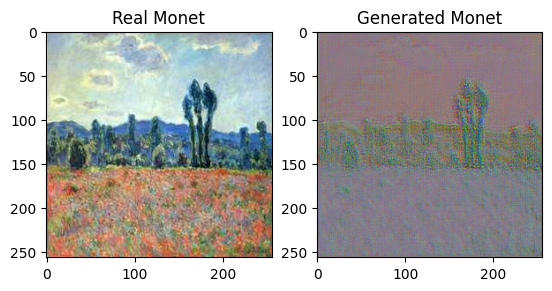

In [20]:
generated_monet_example = monet_generator(monet_example)

plt.subplot(1,2,1)
plt.title("Real Monet")
plt.imshow((monet_example[0]+1)/2)

plt.subplot(1,2,2)
plt.title("Generated Monet")
plt.imshow((generated_monet_example[0]+1)/2)

# CycleGAN Model #

Tuning:
1. Value of LAMBDA, a number between 5 and 10
2. Wasserstein Loss instead of binary cross entropy loss 

In [21]:
class CycleGAN(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10
    ):
        # override model class methods
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lbd = lambda_cycle
        
    def compile(
        self, 
        monet_generator_optimizer,
        photo_generator_optimizer,
        monet_discriminator_optimzer,
        monet_discriminator_optimizer, 
        generator_loss, 
        discriminator_loss, 
        cycle_gan_loss,
        identity_loss
    ):
        super(CycleGAN, self).compile()
        self.m_gen_opt = monet_generator_optimizer
        self.p_gen_opt = photo_generator_optimizer
        self.m_disc_opt = monet_discriminator_optimzer
        self.p_disc_opt = monet_discriminator_optimizer
        self.gen_loss = generator_loss
        self.disc_loss = discriminator_loss
        self.c_gan_loss = cycle_gan_loss
        self.id_loss = identity_loss
        
    def train_step(self, batch):
        real_monet, real_photo = batch
        
        # persistent=True allows multiple calls to gradient
        with tf.GradientTape(persistent=True) as tape:
            # monet to photo to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycle_monet = self.m_gen(fake_photo, training=True)
            
            # photo to monet to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycle_photo = self.p_gen(fake_monet, training=True)
            
            # generate self
            self_monet = self.m_gen(real_monet, training=True)
            self_photo = self.p_gen(real_photo, training=True)
            
            # discrminator output
            real_monet_disc = self.m_disc(real_monet, training=True)
            fake_monet_disc = self.m_disc(fake_monet, training=True)
            real_photo_disc = self.p_disc(real_photo, training=True)
            fake_photo_disc = self.p_disc(fake_photo, training=True)
            
            # generator loss
            monet_gen_loss = self.gen_loss(fake_monet)
            photo_gen_loss = self.gen_loss(fake_photo)
            
            # cycle loss
            cycle_gan_loss = self.c_gan_loss(real_monet, cycle_monet, self.lbd)+self.c_gan_loss(real_photo, cycle_photo, self.lbd)
            
            # total generator loss
            total_monet_gen_loss = monet_gen_loss + cycle_gan_loss + self.id_loss(real_monet, self_monet, self.lbd)
            total_photo_gen_loss = photo_gen_loss + cycle_gan_loss + self.id_loss(real_photo, self_photo, self.lbd)

            # discriminator loss
            monet_disc_loss = self.disc_loss(real_monet_disc, fake_monet_disc)
            photo_disc_loss =  self.disc_loss(real_photo_disc, fake_photo_disc)
        
        # calculate gradients
        monet_gen_grad = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_gen_grad = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_disc_grad = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_disc_grad = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # apply gradients
        self.m_gen_opt.apply_gradients(zip(monet_gen_grad, self.m_gen.trainable_variables))
        self.p_gen_opt.apply_gradients(zip(photo_gen_grad, self.p_gen.trainable_variables))
        self.m_disc_opt.apply_gradients(zip(monet_disc_grad, self.m_disc.trainable_variables))
        self.p_disc_opt.apply_gradients(zip(photo_disc_grad, self.p_disc.trainable_variables))
        
        return {
            "monet generator loss": total_monet_gen_loss,
            "photo generator loss": total_photo_gen_loss,
            "monet discriminator loss": monet_disc_loss,
            "photo discriminator loss": photo_disc_loss
        }

In [22]:
# a perfect discrminator outputs an image filled with 1s for a real image and an image filled with 0s for a fake one.
def discriminator_loss(real, fake):
    # "None" returns the loss for each individual sample
    bce = keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.NONE)
    real_disc_loss = bce(tf.ones_like(real), real)
    fake_disc_loss = bce(tf.zeros_like(fake), fake)
    return (real_disc_loss+fake_disc_loss)/2

In [23]:
# the generator wants to fool the discriminator, therefore it wants the output to always be 1s
def generator_loss(fake):
    bce = keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.NONE)
    return bce(tf.ones_like(fake), fake)

In [24]:
# we want the original and the cycled image to be similar to each other
def cycle_gan_loss(real, cycle, LAMBDA):
    # there is technically no target, so use mean
    return LAMBDA*tf.reduce_mean(tf.abs(real-cycle))

In [25]:
# we want the generation of the same image to be as similar as the original image
def identity_loss(real, self, LAMBDA):
    return LAMBDA*0.5*tf.reduce_mean(tf.abs(real-self))

# Training #

Tuning:

1. Learning rate of optimizers
2. Exponential decay rate of 1st moment estimate (average of gradients)
3. Number of epochs

In [26]:
monet_generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
monet_discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
gan = CycleGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
gan.compile(monet_generator_optimizer, photo_generator_optimizer, monet_discriminator_optimizer, photo_discriminator_optimizer,
            generator_loss, discriminator_loss, cycle_gan_loss, identity_loss)
# this step makes batch operation easier
# double parentheses for zip
gan.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=10)

Epoch 1/10


2023-04-30 21:40:59.364501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype float and shape [7038,256,256,3]
	 [[{{node Placeholder/_5}}]]
2023-04-30 21:40:59.364800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype float and shape [7038,256,256,3]
	 [[{{node Placeholder/_5}}]]


300/300 [==============================] - 299s 811ms/step - monet generator loss: 7.3543 - photo generator loss: 7.7080 - monet discriminator loss: 0.5833 - photo discriminator loss: 0.6203
Epoch 2/10
300/300 [==============================] - 246s 820ms/step - monet generator loss: 6.5283 - photo generator loss: 6.8144 - monet discriminator loss: 0.3034 - photo discriminator loss: 0.3297
Epoch 3/10
300/300 [==============================] - 240s 800ms/step - monet generator loss: 6.1690 - photo generator loss: 6.3845 - monet discriminator loss: 0.1956 - photo discriminator loss: 0.1749
Epoch 4/10
300/300 [==============================] - 233s 778ms/step - monet generator loss: 5.8627 - photo generator loss: 6.0377 - monet discriminator loss: 0.0796 - photo discriminator loss: 0.1048
Epoch 5/10
300/300 [==============================] - 243s 810ms/step - monet generator loss: 5.6106 - photo generator loss: 5.7534 - monet discriminator loss: 0.0845 - photo discriminator loss: 0.1091
E

# Visualize #

1. Why add [0] to the generated image?

2023-04-30 22:22:05.282057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [7038,256,256,3]
	 [[{{node Placeholder/_0}}]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] fo

original tf.Tensor(
[[[0.74509805 0.8392157  0.93333334]
  [0.74509805 0.8392157  0.93333334]
  [0.74509805 0.8392157  0.9411765 ]
  ...
  [0.57254905 0.7529412  0.89411765]
  [0.57254905 0.7529412  0.89411765]
  [0.5686275  0.7490196  0.8901961 ]]

 [[0.7529412  0.84705883 0.9411765 ]
  [0.7490196  0.84313726 0.9372549 ]
  [0.7490196  0.84313726 0.94509804]
  ...
  [0.57254905 0.7529412  0.89411765]
  [0.57254905 0.7529412  0.89411765]
  [0.57254905 0.7529412  0.89411765]]

 [[0.7607843  0.85490197 0.9490196 ]
  [0.7607843  0.85490197 0.9490196 ]
  [0.7529412  0.84705883 0.9490196 ]
  ...
  [0.5686275  0.75686276 0.90588236]
  [0.5686275  0.75686276 0.90588236]
  [0.5686275  0.75686276 0.90588236]]

 ...

 [[0.13333333 0.20784312 0.12156862]
  [0.12549019 0.19999999 0.11372548]
  [0.14509803 0.21960783 0.13333333]
  ...
  [0.10980392 0.19607842 0.10588235]
  [0.13333333 0.21960783 0.12941176]
  [0.12941176 0.21568626 0.12549019]]

 [[0.1490196  0.2235294  0.14509803]
  [0.09803921 0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


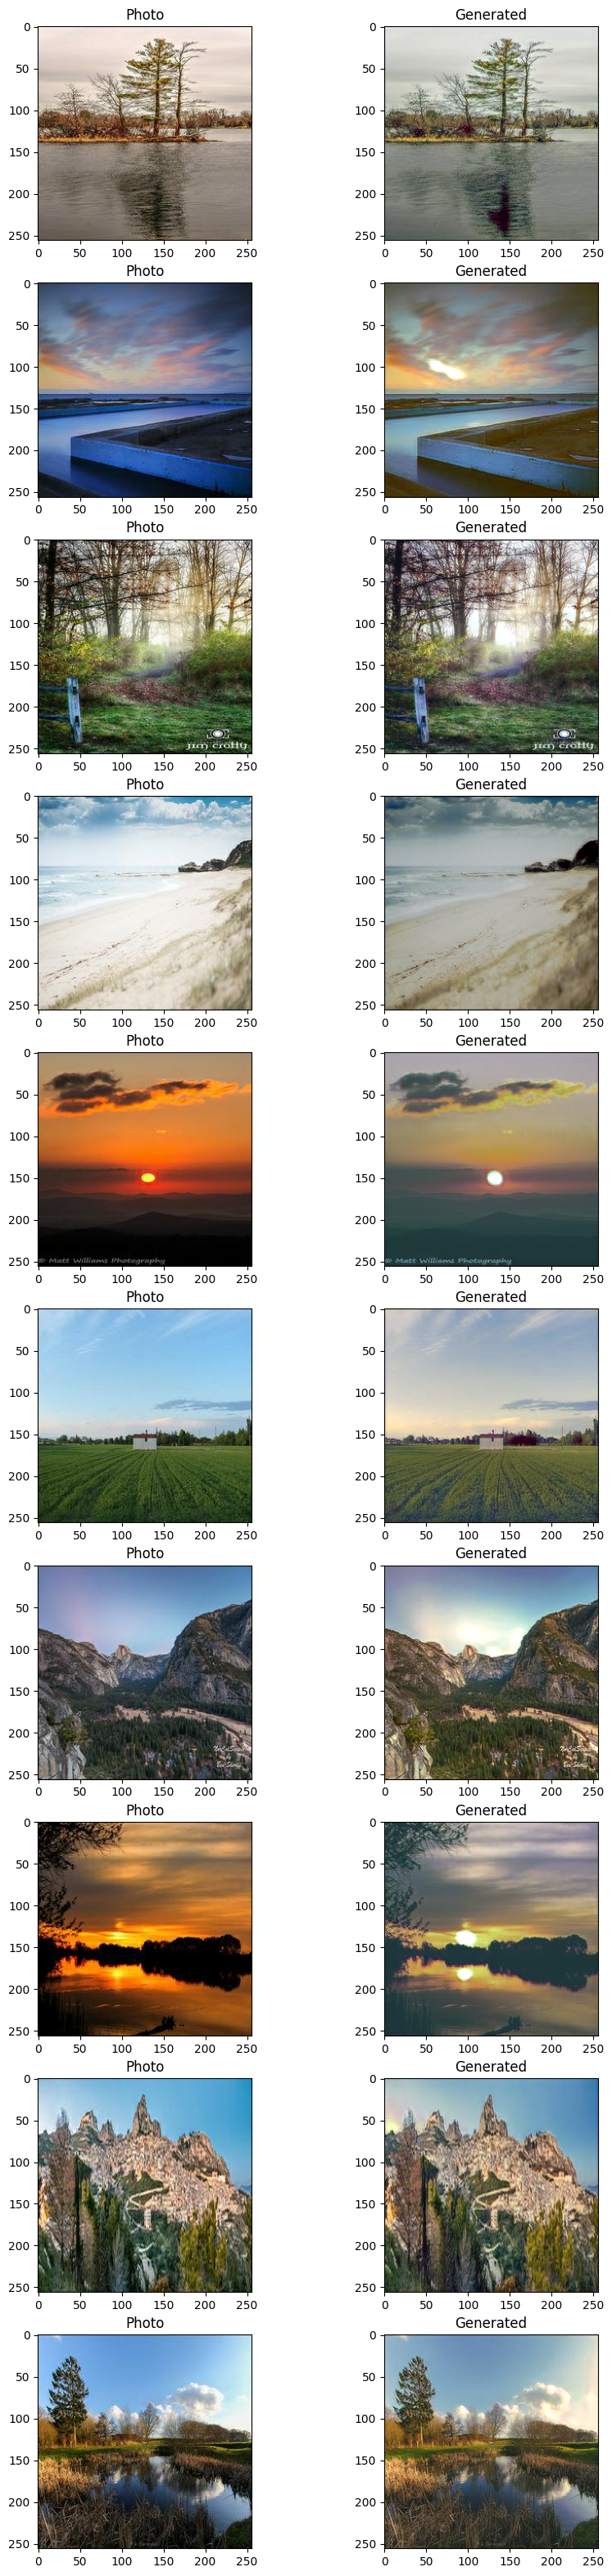

In [28]:
_, ax = plt.subplots(10, 2, figsize=(10, 40))
for i, photo in enumerate(photo_ds.take(10)):
    ax[i,0].set_title("Photo")
    if i==5:
        print("original",(photo[0]+1)/2)
    ax[i,0].imshow((photo[0]+1)/2)
    ax[i,1].set_title("Generated")
    # if i==5:
    #     print("generated",(monet_generator(photo, training=False)[0]+1)/2)
    ax[i,1].imshow((monet_generator(photo, training=False)[0]+1)/2) #maybe add numpy
plt.show()

# Submission #

In [ ]:
for i, photo in enumerate(photo_ds):
    generated = (monet_generator(photo, training=False)[0]+1)/2
    generated_image = PIL.Image.fromarray(generated)
    generated_image.save("./images/"+str(i)+".jpg", "JPEG")

# Performance #

In [31]:
pd.set_option('display.max_colwidth', 0)
performance_df = pd.DataFrame({"Change Log": ["original", "original", "original", "dropout for upsampling in generator 0.5", "random crop * 4 to 224*224*3 images, vgg-inspired architecture for generator", "vgg-inspired architecture for generator"], "Epochs":[10, 25, 100, 10, 10, 10], 
                               "Monet Generator Loss":[2.0564, 1.5475, 1.1673, 2.0624, 3.1842, 4.6802], "Photo Generator Loss":[2.0042, 1.4709, 1.0788, 2.0119, 3.1645, 4.7839], 
                               "Monet Discriminator Loss":[0.1305, 0.1033, 1.5585e-04, 0.1201, 0.0337, 0.0673], "Photo Discriminator Loss":[0.0713, 0.1252, 5.5830e-04, 0.1023, 0.0282, 0.0240], "MiFID":["NA", "NA", "NA", "NA", "NA", "NA"]})
performance_df

,Change Log,Epochs,Monet Generator Loss,Photo Generator Loss,Monet Discriminator Loss,Photo Discriminator Loss,MiFID
0,original,10,2.0564,2.0042,0.130500,0.071300,NA
1,original,25,1.5475,1.4709,0.103300,0.125200,NA
2,original,100,1.1673,1.0788,0.000156,0.000558,NA
3,dropout for upsampling in generator 0.5,10,2.0624,2.0119,0.120100,0.102300,NA
4,"random crop * 4 to 224*224*3 images, vgg-inspired architecture for generator",10,3.1842,3.1645,0.033700,0.028200,NA
5,vgg-inspired architecture for generator,10,4.6802,4.7839,0.067300,0.024000,NA


# Don't Close Laptop Lid #